# Ingest

### Load

In [202]:
import os
from dotenv import load_dotenv
import pandas as pd
from twarc import Twarc2, expansions
from tweet_processing import StreamTweetProcessor

import matplotlib.pyplot as plt
import numpy as np

In [203]:
load_dotenv()

data_dir="../stream-seeding/data" 
twarc_client = Twarc2(
    consumer_key=os.environ["consumer_key"], 
    consumer_secret=os.environ["consumer_secret"],
    access_token=os.environ["access_token"], 
    access_token_secret=os.environ["access_token_secret"]
)

tp = StreamTweetProcessor(twarc_client=twarc_client, data_dir=data_dir)

groups = ["longevity-pranab", "CA-Abundance-Economy"]
following, tweets, refs  = [], [], []
dfs = [following, tweets, refs]

for g in groups: 
    [f, t, r] = tp.load_stream_seed_data(g)
    refs.append(r), tweets.append(t) , following.append(f)

dfs = [pd.concat(df).reset_index() for df in dfs]
df_following, df_tweets, df_refs = dfs

/var/folders/6v/v3k0ftn92ld7ss4w20w4t8480000gn/T/ipykernel_80172/677589303.py:18: DtypeWarning: Columns (45,46,55,62,63,64,65,66,67,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  [f, t, r] = tp.load_stream_seed_data(g)


### Peek

In [204]:
df_tweets = df_tweets.loc[: ,['id', 'text', 'author_id', 'author.username',  'created_at', 
                              'public_metrics.like_count', 'public_metrics.quote_count', 'public_metrics.reply_count', 
                              'public_metrics.retweet_count','attachments.media','attachments.media_keys', 'referenced_tweets.replied_to.id', 
                              'referenced_tweets.retweeted.id', 'referenced_tweets.quoted.id', 'in_reply_to_user_id','retweeted_user_id', 'quoted_user_id']]


df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'])

# merge the tweets with the references
ref_cols = ['referenced_tweets.replied_to.id', 'referenced_tweets.retweeted.id', 'referenced_tweets.quoted.id']
df_tweets['referenced'] = df_tweets.loc[:, ref_cols].any(axis=1)

auth_ref_cols = ['in_reply_to_user_id','retweeted_user_id', 'quoted_user_id']
df_tweets['referenced_authors'] = df_tweets.loc[:, auth_ref_cols].any(axis = 1)

# convert to int
df_tweets.loc[:, ref_cols + auth_ref_cols] = df_tweets.loc[:, ref_cols + auth_ref_cols].fillna(0).astype(int)

frac_id = sum(df_tweets['referenced_authors'] == df_tweets['referenced'])/len(df_tweets)
print(f"{frac_id*100:.2f}% of referenced tweets have associated accounts")

# ensure consistency in id/name
assert df_tweets.author_id.value_counts().to_list() ==  df_tweets["author.username"].value_counts().to_list()
# assert ref/ref author consistency

df_tweets.head()

99.63% of referenced tweets have associated accounts


,id,text,author_id,author.username,created_at,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,attachments.media,attachments.media_keys,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,in_reply_to_user_id,retweeted_user_id,quoted_user_id,referenced,referenced_authors
0,1546652638917275649,I'd like to have fluency with basic game theor...,301427990,LauraDeming,2022-07-12 00:28:19+00:00,75,1,13,1,NaN,NaN,0,0,0,0,0,0,False,False
1,1546636515920322560,I wish there was a Serious Eats but for bio pr...,301427990,LauraDeming,2022-07-11 23:24:15+00:00,20,0,3,1,NaN,NaN,0,0,0,0,0,0,False,False
2,1542617941480333314,"Half of it reads like a modern Medium post, th...",301427990,LauraDeming,2022-06-30 21:15:52+00:00,10,0,0,0,NaN,NaN,1542617483420368896,0,0,301427990,0,0,True,True
3,1542617483420368897,Thanks @michael_nielsen for pointing out that ...,301427990,LauraDeming,2022-06-30 21:14:03+00:00,18,0,2,2,NaN,NaN,1542615757460082688,0,0,301427990,0,0,True,True
4,1542615757460082688,I wrote a personal post about how 28 feels dif...,301427990,LauraDeming,2022-06-30 21:07:11+00:00,140,0,12,7,NaN,NaN,0,0,0,0,0,0,False,False


In [205]:
df_tweets['attachments.media'].describe(), df_tweets['attachments.media_keys'].describe()

(count     2201
 unique    1720
 top       [{}]
 freq       400
 Name: attachments.media, dtype: object,
 count                           2201
 unique                          2190
 top       ["13_1529246312641597441"]
 freq                               2
 Name: attachments.media_keys, dtype: object)

# EDA


In [206]:
# Counting "pure" tweets
# TODO: include/exclude retweets, urls
# TODO: use df_tweets.entities.mentions.usernames to exempt from preprocessing

n = df_tweets['attachments.media'].isna().sum()/df_tweets.shape[0]
print(f"Percentage of tweets without media: {n:.2%}")

Percentage of tweets without media: 87.46%


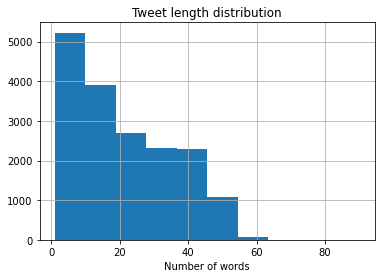

In [207]:
# Normalised hist
df_tweets.text.apply(lambda x: len(x.split())).hist()
plt.title("Tweet length distribution")
plt.xlabel("Number of words")
plt.show()

In [208]:
# Create a Filtered Dataset

# Drop one word tweets
df_filtered = df_tweets[df_tweets.text.apply(lambda x: len(x.split()))  > 1]

# Drop duplicates
df_filtered = df_filtered.drop_duplicates(subset=['text'])

# Drop referenced tweets
df_filtered = df_filtered[df_filtered.referenced == False]

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

print(f"Dataset size: {df_filtered.shape[0]} tweets, reduced by {df_tweets.shape[0] - df_filtered.shape[0]} tweets" )

Dataset size: 3031 tweets, reduced by 14519 tweets


# Preprocessing

In [209]:
# Get tweets from 301427990
authors = df_filtered['author.username'].value_counts().to_dict()

for author in authors.keys():
    # Get tweet indices
    authors[author] = df_filtered[df_filtered['author.username'] == author].index.to_list()

In [210]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tweets = df_tweets.text.values
filtered_tweets = df_filtered.text.values

len(tweets), tweets[:3]

(17550,
 array(["I'd like to have fluency with basic game theory well enough to have intuition for the situations presented in Parfit's 'Reasons and Persons'. Any suggestions for a text or tutor?\\n\\nWant to build really strong, simple intuitions to go with the relevant equations - nothing fancy.",
        'I wish there was a Serious Eats but for bio protocols.',
        "Half of it reads like a modern Medium post, the other half contains such wisdom as\\n\\n'You should not buy a donkey which brays; it will split (?) your midriff (?).'\\n\\n'You should not pass judgment when you drink beer.'\\n\\n'Fate is a wet bank; it can make one slip.'"],
       dtype=object))

In [211]:
import re

def preprocess(text):
    text = text.lower()
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # replace first \n with space
    text = re.sub(r'\\n', ' ', text)
    
    # remove unicode characters, except @ and #
    text = re.sub(r'[^\x00-\x7f]',r' ', text)

    return text

t = 3
preprocess(tweets[t]), tweets[t]

("thanks @michael_nielsen for pointing out that many of the first books in history were generic self-help advice pieces, and that i was thus joining a long and venerable tradition.  although i'm not sure one can beat gems from 'instructions of shuruppag'. ",
 "Thanks @michael_nielsen for pointing out that many of the first books in history were generic self-help advice pieces, and that I was thus joining a long and venerable tradition.\\n\\nAlthough I'm not sure one can beat gems from 'instructions of Shuruppag'.\\nhttps://t.co/e5Wacy1AIz")

# Doc-Term Similarity

In [212]:
# Tokenize tweets
# TODO: investigate nltk vs inbuilt stop_words
# TODO: handle @mentions :: named entity recog?

vectorizer = CountVectorizer(strip_accents = 'unicode', stop_words='english', preprocessor=preprocess)
X = vectorizer.fit_transform(filtered_tweets)

# tfidf on tweets
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode', stop_words='english', preprocessor=preprocess)
tfidf = tfidf_vectorizer.fit_transform(filtered_tweets)

assert sum([len(i) for i in authors.values()]) == X.shape[0] and tfidf.shape == X.shape

In [213]:
# TODO: How similar are tweets from same author? 
author_docs = dict.fromkeys(authors.keys(), [])

for author in authors.keys():
    # Sum and average tfidf vectors for each author
    mat = tfidf[authors[author], :].sum(axis=0)
    author_docs[author] = np.squeeze(np.asarray(mat))

# Ensure a nonce has the same tfidf in author_docs and tweet_docs
id = tfidf_vectorizer.vocabulary_['intuitions']

#  assert mat[:, id].sum() == tfidf[:, id].sum()

In [214]:
# measure distance between tweets
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

docs = np.vstack(list(author_docs.values()))

# similarity matrices
cosine = cosine_similarity(docs)
euclidean = euclidean_distances(docs)

In [215]:
def most_similar(author :int, sim_mat: np.array, n = 2):
    # return most similar author
    i = list(author_docs.keys()).index(author)
    
    v = sim_mat[i, :]

    if sim_mat.min() == 0:
        # Euclidean
        v = np.argsort(v)
    else:
        # Cosine
        v = np.argsort(v)[::-1]

    auth_idxs = v[1:n+1]
    auths = [list(author_docs.keys())[i] for i in auth_idxs]
    
    return auths

long_users = ['celinehalioua', 'ArtirKel', 'LauraDeming']
ca_users = ['anniefryman', 'rklau', 'hanlonbt' ]

# sanity check
for a in author_docs.keys():
    x = np.vstack([author_docs['rklau'], author_docs[a]])

    # Cosine similarity
    print(cosine_similarity(x)[0,1], a)

most_similar('rklau', cosine, 3)

0.44122382169308355 celinehalioua
0.4239273718767329 LauraDeming
0.4527964132321405 anniefryman
1.0000000000000016 rklau
0.24254279765505593 hanlonbt
0.27820781687401513 ArtirKel


['anniefryman', 'celinehalioua', 'LauraDeming']

In [216]:
def completion_accuracy(source_acc: str, recs: list):
    # source_acc = account to recommend from
    # recs = list of recommended accounts
    # returns TP count

    if source_acc in long_users:
        target_set = set(long_users)
    elif source_acc in ca_users:
        target_set = set(ca_users)
    else:
        raise ValueError("source_acc not in any set")
    
    target_set.remove(source_acc)
    tp = len(set(recs).intersection(target_set))
    return tp

completion_accuracy('rklau', most_similar('rklau', cosine, 3))

1

In [217]:
from math import perm
from itertools import permutations

# Generalises to n authors
def random_acc(n_authors: int, n_recs: int) -> float:
    # Return accuracy of random assignment
    # eg P(1/2 correct AND 2/2 correct) = 1 - P(0/2 correct) = 1 - (n-r)/n

    # Total authors to recommend from, exempting source
    n = n_authors - 1
    # Number of recommendations to make
    r = n_recs

    return 1 - (n - r)/n

    # i is number of true positives
    p_0 = 0
    for i in range(1, r+1):

        base_arr = np.zeros(r)
        base_arr[:i] = 1

        perms = list(set(permutations(base_arr, r)))

        p_1 = 0
        for permutation in perms: 
            p_2 = 1
            for idx,p in enumerate(permutation):
                if p == 1:
                    p_2 *= 1/(n-idx)
                elif p == 0:
                    p_2 *= (n-idx-1)/(n-idx)
            p_1 += p_2
        p_0 += p_1

    return p_0


random_acc(6, 2)

0.4

In [218]:
def accuracy(accounts: list, sim_mat, n_rec = 3, show_outputs = False):
    accs = []
    for rec in range(1, n_rec+1):
        tp = 0
        rand_p = 0
        n_acc = len(accounts)
        
        # each account(acc) is a seed for rec(int) account recommendations
        for acc in accounts:
            
            # create a list of rec(int) accounts
            recs = most_similar(acc, sim_mat, n=rec)
            # measure hit rate
            hits = completion_accuracy(acc, recs)

            rand_recs = [accounts[i] for i in np.random.choice(n_acc, rec, replace=False)]
            while acc in rand_recs:
                rand_recs = [accounts[i] for i in np.random.choice(n_acc, rec, replace=False)]
            rand_hits = completion_accuracy(acc, rand_recs)
            
            if rec == 2:
                print(f"Similarity  | {acc} -> {recs} : {hits}")
                print(f"Random      | {acc} -> {rand_recs} : {rand_hits} \n")

            tp += hits
            rand_p += rand_hits
        
        accuracy = tp/(2*n_acc)
        accs.append(accuracy)
        rand_accuracy = rand_p/(2*n_acc)

        if show_outputs or rec == 2:
            print(f"Accuracy for {rec} recommendation{'s' if rec > 1 else ''}")
            print(f"\t Doc-Term Similarity Recommendation: {accuracy:.2%}")
            print(f"\t (Empirical) Random Assignment: {rand_accuracy:.2%}")
            print(f"\t (Analytical) Random Assignment: {random_acc(len(accounts),rec):.2%}")
    return accs


accounts = ca_users + long_users
cosine_accuracies = accuracy(accounts, sim_mat = cosine, n_rec = 5)

Similarity  | anniefryman -> ['rklau', 'celinehalioua'] : 1
Random      | anniefryman -> ['celinehalioua', 'LauraDeming'] : 0 

Similarity  | rklau -> ['anniefryman', 'celinehalioua'] : 1
Random      | rklau -> ['LauraDeming', 'ArtirKel'] : 0 

Similarity  | hanlonbt -> ['anniefryman', 'rklau'] : 2
Random      | hanlonbt -> ['celinehalioua', 'anniefryman'] : 1 

Similarity  | celinehalioua -> ['LauraDeming', 'anniefryman'] : 1
Random      | celinehalioua -> ['anniefryman', 'rklau'] : 0 

Similarity  | ArtirKel -> ['LauraDeming', 'celinehalioua'] : 2
Random      | ArtirKel -> ['celinehalioua', 'rklau'] : 1 

Similarity  | LauraDeming -> ['celinehalioua', 'rklau'] : 1
Random      | LauraDeming -> ['celinehalioua', 'hanlonbt'] : 1 

Accuracy for 2 recommendations
	 Doc-Term Similarity Recommendation: 66.67%
	 (Empirical) Random Assignment: 25.00%
	 (Analytical) Random Assignment: 40.00%


In [219]:
euclidean_accuracies = accuracy(accounts, sim_mat = euclidean, n_rec = 5)

Similarity  | anniefryman -> ['rklau', 'ArtirKel'] : 1
Random      | anniefryman -> ['ArtirKel', 'hanlonbt'] : 1 

Similarity  | rklau -> ['ArtirKel', 'anniefryman'] : 1
Random      | rklau -> ['LauraDeming', 'ArtirKel'] : 0 

Similarity  | hanlonbt -> ['ArtirKel', 'rklau'] : 1
Random      | hanlonbt -> ['anniefryman', 'LauraDeming'] : 1 

Similarity  | celinehalioua -> ['LauraDeming', 'anniefryman'] : 1
Random      | celinehalioua -> ['LauraDeming', 'hanlonbt'] : 1 

Similarity  | ArtirKel -> ['rklau', 'hanlonbt'] : 0
Random      | ArtirKel -> ['hanlonbt', 'LauraDeming'] : 1 

Similarity  | LauraDeming -> ['rklau', 'ArtirKel'] : 1
Random      | LauraDeming -> ['rklau', 'hanlonbt'] : 0 

Accuracy for 2 recommendations
	 Doc-Term Similarity Recommendation: 41.67%
	 (Empirical) Random Assignment: 33.33%
	 (Analytical) Random Assignment: 40.00%


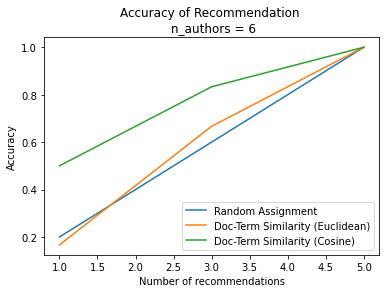

In [220]:
# See how accuracy scales with n
n_authors = 6
n_recs = range(1, n_authors)

random_accs = [random_acc(n_authors, n) for n in n_recs]

# plot
plt.plot(n_recs, random_accs, label = 'Random Assignment')
# plot docterm accuracy
plt.plot(n_recs, euclidean_accuracies, label='Doc-Term Similarity (Euclidean)')
plt.plot(n_recs, cosine_accuracies, label='Doc-Term Similarity (Cosine)')

plt.xlabel('Number of recommendations')
plt.ylabel('Accuracy')
plt.title(f"Accuracy of Recommendation \n n_authors = {n_authors}")


plt.legend()
plt.show()

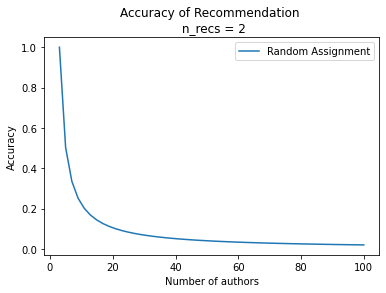

In [221]:
# See how accuracy scales with n_authors
n_authors = np.linspace(3, 100)
n_recs = 2

random_accs = [random_acc(n, n_recs) for n in n_authors]

plt.plot(n_authors, random_accs, label = 'Random Assignment')
plt.xlabel('Number of authors')
plt.ylabel('Accuracy')
plt.title(f"Accuracy of Recommendation \n n_recs = {n_recs}")
plt.legend()
plt.show()

# Social-Content Tweet Graph

## Seed Origin Graph

In [222]:
import networkx as nx

usernames = long_users + ca_users

# sanity checks

# total following count
df_following['referencer.username'].value_counts(), df_tweets['author.username'].value_counts()

(rklau            4479
 celinehalioua    2249
 hanlonbt         2132
 anniefryman      1371
 ArtirKel          919
 LauraDeming       140
 Name: referencer.username, dtype: int64,
 celinehalioua    3248
 ArtirKel         3238
 anniefryman      3209
 rklau            3200
 hanlonbt         3198
 LauraDeming      1457
 Name: author.username, dtype: int64)

In [223]:
G = nx.DiGraph()

tweet_nodes = [(i, {"tweet": text})
               for i, text in zip(df_tweets.id, df_tweets.text)]
author_nodes = [(i, {"user": name}) for i, name in zip(
    df_tweets.author_id, df_tweets["author.username"])]
usernameToId = {data['user']: i for i, data in author_nodes}

assert len(np.unique([i[0] for i in author_nodes])) == 6

G.add_nodes_from(tweet_nodes), G.add_nodes_from(author_nodes)


# add content graph
for i, row in df_tweets.iterrows():
    # pure tweet
    G.add_edge(row.author_id, row.id, relation="tweeted")

    if row.referenced:
        for ref in ref_cols:
            if row[ref] != 0:
                # id of tweet being referenced
                ref_tweet = row[ref]
                ref_type = ref.split(".")[1].split("_")[0]

                # Add reference tweet to graph
                G.add_node(row[ref], tweet=f"N/A")
                G.add_edge(row.id, row[ref], relation=ref_type)

                # Add author of referenced tweet to graph
                ref_source_acc = row[auth_ref_cols].values.any()

                G.add_node(ref_source_acc, user=f"N/A")
                G.add_edge(ref_source_acc, row[ref], relation="tweeted")
        

# add social graph
for i, row in df_following.iterrows():

    follower = usernameToId[row["referencer.username"]]
    author = (row.id, {"user": row.username})

    G.add_nodes_from([author])
    G.add_edge(follower, author[0], relation="follows")


In [224]:
df_tweets.loc[df_tweets["author.username"] == "LauraDeming", "referenced"].sum()

679

## Graph Descriptive Statistics

Number of nodes: 43297
Node types: 	 {'tweet': 31089, 'user': 12208}

Number of edges: 57265
Edge types: 	 {'replied': 10681, 'retweeted': 2534, 'quoted': 1583, 'tweeted': 31177, 'follows': 11290}
Density: 	 3.054806348717322e-05
Avg. # edges:	 1.3226089567406518


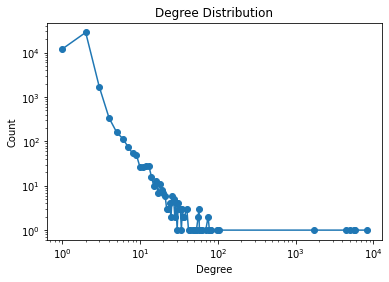

In [225]:
from collections import Counter

# Descriptive Stats
def describe_graph(G : nx.Graph):
    print(f"Number of nodes: {G.number_of_nodes()}")
    node_types = dict(Counter(["".join(i[1].keys()) for i in G.nodes(data=True)]))
    print(f"Node types: \t {node_types}")

    print(f"\nNumber of edges: {G.number_of_edges()}")
    edge_types = dict(Counter(["".join(i[2].values()) for i in G.edges(data=True)]))
    print(f"Edge types: \t {edge_types}")
    
    print(f"Density: \t {nx.density(G)}")
    print(f"Avg. # edges:\t {len(G.edges)/G.number_of_nodes()}")
    
    # node degree distribution
    deg, cnt = np.unique(sorted((d for n, d in G.degree()), reverse=True), return_counts=True)
    plt.loglog(deg, cnt, 'o-')
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.title("Degree Distribution")
    plt.show()
describe_graph(G)

In [229]:
# pure tweets vs tweets with references
def is_pure(tweet_id: int, G: nx.Graph):
    # A pure tweet is a tweet that has no references/outgoing edges
    return len(G.edges(tweet_id, data=True)) == 0

def describe_node(node: str or int,  G: nx.Graph, data = False):
    # Summary stats on an individual author node
    if type(node) == str:
        username = node
        user_id = usernameToId[username]
        print(f"ID: \t \t {user_id}")
        edges = G.edges(user_id, data=True)
        print(f"Username: \t {username}")
    else: 
        edges = G.edges(node, data=True)
    

    tweets = set(i[1] for i in edges if i[2].get('relation') == 'tweeted')

    pure_tweets = set(i for i in tweets if is_pure(i, G))
    ref_tweets  = tweets - pure_tweets

    if data: 
        return {"pure": list(pure_tweets), "refs": list(ref_tweets)}

    # Statistics on edges
    print(f"Total Edges: \t {len(edges)}")
    # Count of each edge type
    print(f"Edge Types: \t {dict(Counter([i[2]['relation'] for i in edges]))}")
    print(f"\nPure Tweets: \t {len(pure_tweets)}")
    print(f"Ref Tweets:  \t {len(ref_tweets)}")
    print(f"% Pure: \t {(len(pure_tweets)/len(tweets))*100:.2f}%")
    return


describe_node("LauraDeming", G)

ID: 	 	 301427990
Username: 	 LauraDeming
Total Edges: 	 1718
Edge Types: 	 {'tweeted': 1578, 'follows': 140}

Pure Tweets: 	 899
Ref Tweets:  	 679
% Pure: 	 56.97%


## Social-Content Subgraph
Isolate account - tweet - account links. 
Treat "Pure Tweets" as aggregates to process. 

In [227]:
subgraph_nodes = []

source_authors = np.unique([i for i,j in author_nodes])

for a in source_authors: 
    subgraph_nodes.append(a)

    tweet_breakdown = describe_node(a, G, data=True)

    for ref_tweet in tweet_breakdown["refs"]:
        subgraph_nodes.append(ref_tweet)

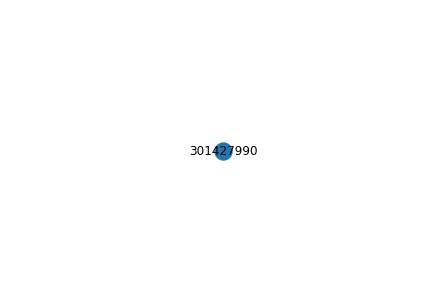

In [228]:
subgraph = G.subgraph((301427990))

nx.draw(subgraph, with_labels=True)